## Step 1: Import Libraries & Load Dataset

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import os

# Create folders

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)


# Load Breast Cancer dataset from sklearn
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df = data.frame
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Step 2: Data Preparation

In [2]:

# Features and target
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Step 3: Model Training Without Feature Selection

In [3]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

metrics_list = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_list.append([name, "Without Feature Selection", acc, prec, rec, f1])
    
    # Save model
    joblib.dump(model, f"models/{name.replace(' ', '_')}_without.pkl")


## Step 4: Feature Selection and Model Training With Selection

In [4]:

# Select top 10 features using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics_list.append([name, "With Feature Selection", acc, prec, rec, f1])
    
    # Save model
    joblib.dump(model, f"models/{name.replace(' ', '_')}_with.pkl")


Selected Features: ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


## Step 5: Save Metrics to CSV

In [5]:

df_metrics = pd.DataFrame(metrics_list, columns=["Model", "Feature Selection", "Accuracy", "Precision", "Recall", "F1-Score"])
df_metrics.to_csv("results/metrics.csv", index=False)
df_metrics


,Model,Feature Selection,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,Without Feature Selection,0.982456,0.986111,0.986111,0.986111
1,Random Forest,Without Feature Selection,0.956140,0.958904,0.972222,0.965517
2,Logistic Regression,With Feature Selection,0.947368,0.971429,0.944444,0.957746
3,Random Forest,With Feature Selection,0.956140,0.958904,0.972222,0.965517


## Step 6: Visualization of Results

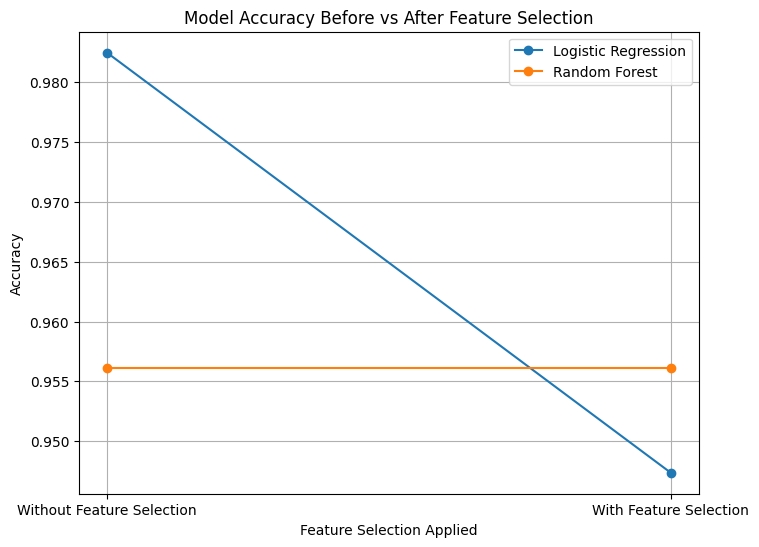

<Figure size 800x600 with 0 Axes>

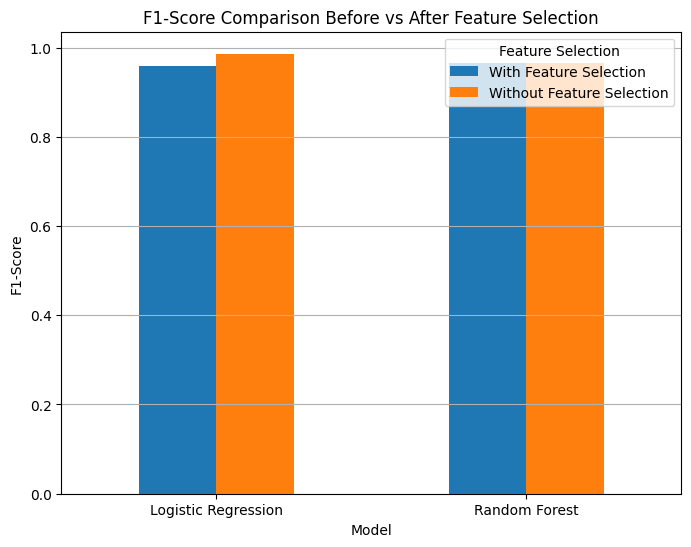

In [6]:

# Load metrics
df_metrics = pd.read_csv("results/metrics.csv")

# Plot Accuracy comparison (line plot)
plt.figure(figsize=(8,6))
for model in df_metrics['Model'].unique():
    subset = df_metrics[df_metrics['Model'] == model]
    plt.plot(subset['Feature Selection'], subset['Accuracy'], marker='o', label=model)

plt.title("Model Accuracy Before vs After Feature Selection")
plt.xlabel("Feature Selection Applied")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("results/accuracy_comparison.png")
plt.show()

# Bar plot for F1-Score
plt.figure(figsize=(8,6))
df_plot = df_metrics.pivot(index="Model", columns="Feature Selection", values="F1-Score")
df_plot.plot(kind="bar", figsize=(8,6))
plt.title("F1-Score Comparison Before vs After Feature Selection")
plt.ylabel("F1-Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.savefig("results/f1score_comparison.png")
plt.show()
